In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
from dask.distributed import Client
import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gsw

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from log_progress import log_progress


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Bottom layer maps

In [2]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t00_04.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).mean('time')
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s00_04.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).mean('time')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

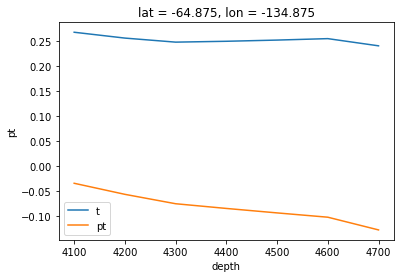

In [244]:
woa_t.t_an[-15:,-1,180].plot(label='t')
woa_t.pt[-15:,-1,180].plot(label='pt')
plt.legend()

In [4]:
lat_2d,depth_2d = np.meshgrid(woa_t.lat,woa_t.depth)
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],woa_t.lon.size,axis=2)
woa_t['depth_3d'] = xr.DataArray(depth_3d, dims=woa_t.dims)
woa_t['max_depth'] = woa_t.depth_3d.where(~woa_t.t_an.isnull()).max('depth')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [241]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

#avg_path = os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc')
#avg = xr.open_dataset(avg_path)

#temp = avg.temp.mean('ocean_time')
#salt = avg.salt.mean('ocean_time')
temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
#zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_DJFavg.nc')
temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
#zeta = xr.open_dataset(zeta_path).zeta.squeeze()

In [246]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

#mask = (grd.zice==0) & (grd.lat_rho <=65)

temp_out = regrid(temp)
salt_out = regrid(salt)
z_out = regrid(grd.z)
#depth_3d = regrid(grd.z.where(grd.zice==0))
#dz_out = regrid(grd.dz.where(grd.zice==0))

Create weight file: nearest_s2d_2650x3150_61x1440.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


Reuse existing file: nearest_s2d_2650x3150_61x1440.nc
Reuse existing file: nearest_s2d_2650x3150_61x1440.nc


In [247]:
from scipy import interpolate

def interp_max_depth(waom_out):
    out = woa_t.max_depth.copy()
    for i in log_progress(np.arange(out.lat.size)):
        for j in np.arange(out.lon.size):
            f = interpolate.interp1d(-z_out[:,i,j],waom_out[:,i,j],bounds_error=False)
            out[i,j] = f(woa_t.max_depth[i,j])
            
    return xr.DataArray(out,dims=('lat','lon'))

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = interpolate.LinearNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

def main(waom_out):
    waom_deep = interp_max_depth(waom_out)
    waom_deep.values = NDinterp(waom_deep.values)
    waom_deep = waom_deep.where(~woa_t.max_depth.isnull())
    
    return waom_deep
    
temp_deep = main(temp_out)
salt_deep = main(salt_out)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


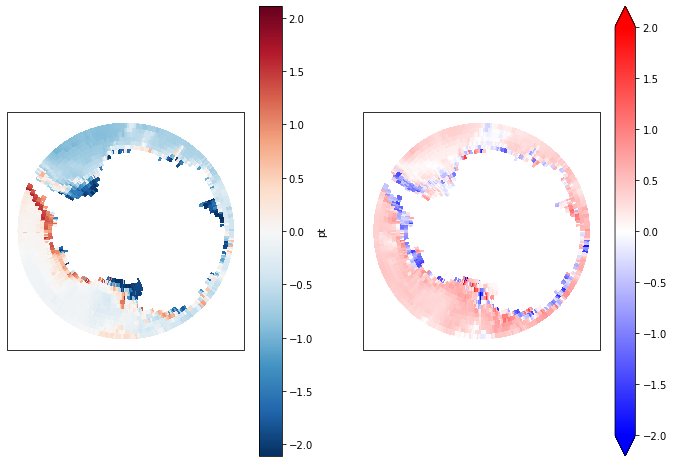

In [178]:
woa_pt = woa_t.pt.where(woa_t.depth_3d == woa_t.max_depth).max('depth')

fig = plt.figure(figsize = (11.69, 8.27))

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = woa_pt.plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = (temp_deep-woa_pt).plot(ax=ax2,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


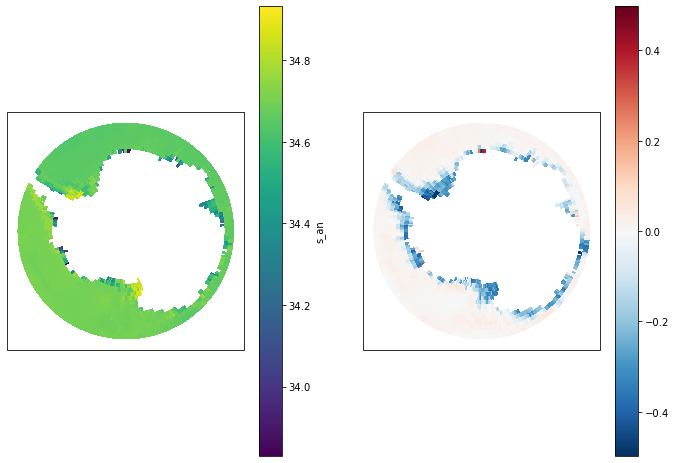

In [138]:
woa_salt = woa_s.s_an.where(woa_t.depth_3d == woa_t.max_depth).max('depth')

fig = plt.figure(figsize = (11.69, 8.27))

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = woa_salt.plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = (salt_deep-woa_salt).plot(ax=ax2,transform = ccrs.PlateCarree())

In [248]:
ecco_path = os.path.join(proj_dir,'data','preprocessing','external','ecco2','THETA.nc','THETA.1440x720x50.2007??.nc')
ecco_t = xr.open_mfdataset(ecco_path,decode_times=False).THETA.sel({'LATITUDE_T':slice(-80,-65)}).mean('TIME').load()
ecco_path = os.path.join(proj_dir,'data','preprocessing','external','ecco2','SALT.nc','SALT.1440x720x50.2007??.nc')
ecco_s = xr.open_mfdataset(ecco_path,decode_times=False).SALT.sel({'LATITUDE_T':slice(-80,-65)}).mean('TIME').load()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [249]:
import xesmf as xe

lon = ecco_t.LONGITUDE_T.values.copy()
lon[lon>180]-=360
ecco_t['lon'] = xr.DataArray(lon,dims=('LONGITUDE_T'))
def regrid(da):
    da = da.assign_coords({'lat':ecco_t.LATITUDE_T,'lon':ecco_t.lon})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

#mask = (grd.zice==0) & (grd.lat_rho <=65)

ecco_t_out = regrid(ecco_t)
ecco_s_out = regrid(ecco_s)

lat_2d,depth_2d = np.meshgrid(ecco_t_out.lat,ecco_t_out.DEPTH_T)
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],ecco_t_out.lon.size,axis=2)
ecco_t_out['depth_3d'] = xr.DataArray(depth_3d, dims=ecco_t_out.dims)
ecco_t_out['max_depth'] = ecco_t_out.depth_3d.where(~ecco_t_out.isnull()).max('DEPTH_T')
#z_out = regrid()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


Create weight file: nearest_s2d_60x1440_61x1440.nc
Reuse existing file: nearest_s2d_60x1440_61x1440.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [250]:
from scipy import interpolate

def interp_max_depth(waom_out):
    out = woa_t.max_depth.copy()
    for i in log_progress(np.arange(out.lat.size)):
        for j in np.arange(out.lon.size):
            f = interpolate.interp1d(ecco_t_out.depth_3d[:,i,j],waom_out[:,i,j],bounds_error=False)
            out[i,j] = f(woa_t.max_depth[i,j])
            
    return xr.DataArray(out,dims=('lat','lon'))

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = interpolate.LinearNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

def main(waom_out):
    waom_deep = interp_max_depth(waom_out)
    waom_deep.values = NDinterp(waom_deep.values)
    waom_deep = waom_deep.where(~woa_t.max_depth.isnull())
    
    return waom_deep
    
ecco_t_out_deep = main(ecco_t_out)
ecco_s_out_deep = main(ecco_s_out)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


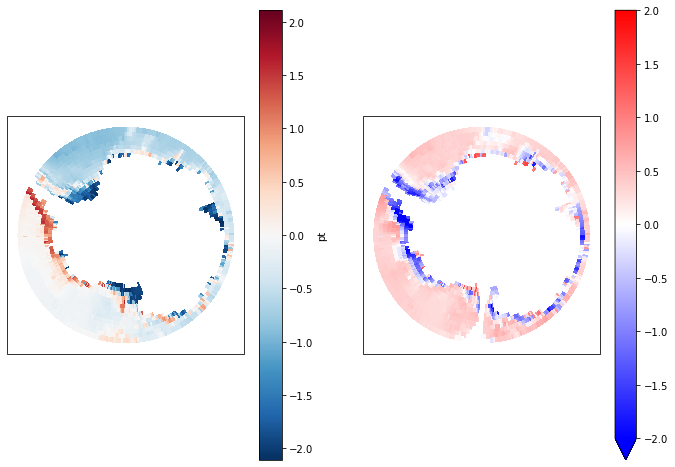

In [188]:
woa_pt = woa_t.pt.where(woa_t.depth_3d == woa_t.max_depth).max('depth')

fig = plt.figure(figsize = (11.69, 8.27))

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = woa_pt.plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = (ecco_t_out_deep-woa_pt).plot(ax=ax2,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


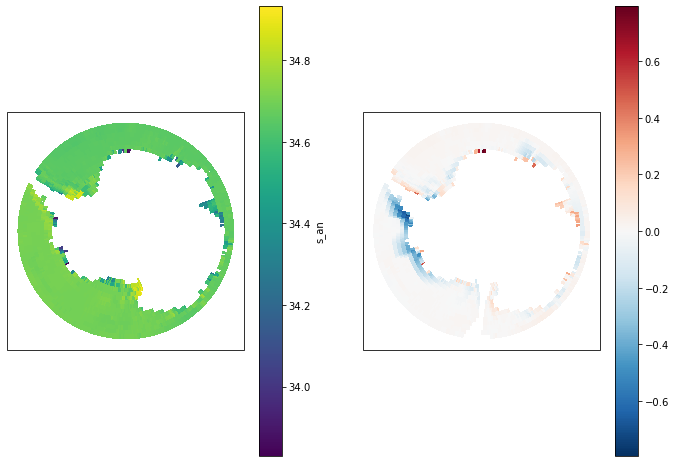

In [189]:
woa_pt = woa_s.s_an.where(woa_t.depth_3d == woa_t.max_depth).max('depth')

fig = plt.figure(figsize = (11.69, 8.27))

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = woa_pt.plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = (ecco_s_out_deep-woa_pt).plot(ax=ax2,transform = ccrs.PlateCarree())

# Plotting

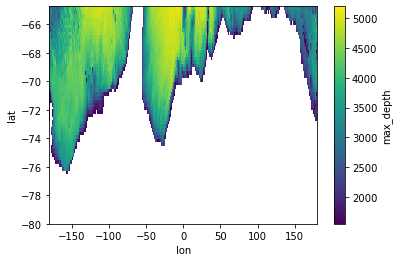

In [270]:
woa_t.max_depth.where(woa_t.max_depth>1500).plot()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


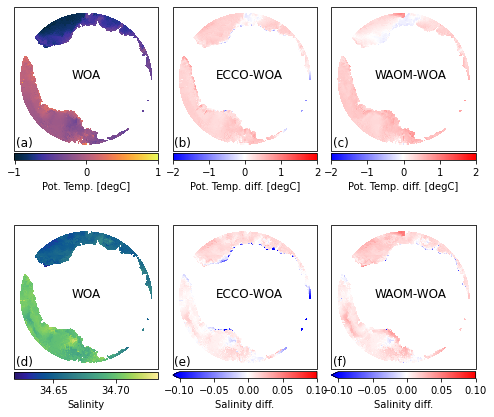

In [284]:
import string
fig = plt.figure(figsize = (8.27, 8.))

mask_deep = woa_t.max_depth > 3000 

woa_pt = woa_t.pt.where(woa_t.depth_3d == woa_t.max_depth).max('depth').where(mask_deep)
ax1 = fig.add_subplot(231, projection = ccrs.SouthPolarStereo())
woa_pt.plot(ax=ax1,transform = ccrs.PlateCarree(),cmap=ocm.thermal,
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [degC]','pad':0.01})

ax2 = fig.add_subplot(232, projection = ccrs.SouthPolarStereo())
(ecco_t_out_deep-woa_pt).where(mask_deep).plot(ax=ax2,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax3 = fig.add_subplot(233, projection = ccrs.SouthPolarStereo())
(temp_deep-woa_pt).where(mask_deep).plot(ax=ax3,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

woa_salt = woa_s.s_an.where(woa_t.depth_3d == woa_t.max_depth).max('depth').where(mask_deep)
vmin = woa_salt.mean()-1*woa_salt.std()
vmax = woa_salt.mean()+1*woa_salt.std()
ax4 = fig.add_subplot(234, projection = ccrs.SouthPolarStereo())
woa_salt.plot(ax=ax4,transform = ccrs.PlateCarree(),cmap=ocm.haline,
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity','pad':0.01})

ax5 = fig.add_subplot(235, projection = ccrs.SouthPolarStereo())
(ecco_s_out_deep-woa_salt).where(mask_deep).plot(ax=ax5,transform = ccrs.PlateCarree(),vmin=-0.1,vmax=0.1,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})

ax6 = fig.add_subplot(236, projection = ccrs.SouthPolarStereo())
(salt_deep-woa_salt).where(mask_deep).plot(ax=ax6,transform = ccrs.PlateCarree(),vmin=-0.1,vmax=0.1,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Salinity diff.','pad':0.01})
n=0
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    #ax.set_xlabel('Salinity (psu)')    
    ax.text(0.01, 0.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    
ax1.text(0.4, 0.5, "WOA", transform=ax1.transAxes,size=12)
ax2.text(0.3, 0.5, "ECCO-WOA", transform=ax2.transAxes,size=12)
ax3.text(0.3, 0.5, "WAOM-WOA", transform=ax3.transAxes,size=12)
ax4.text(0.4, 0.5, "WOA", transform=ax4.transAxes,size=12)
ax5.text(0.3, 0.5, "ECCO-WOA", transform=ax5.transAxes,size=12)
ax6.text(0.3, 0.5, "WAOM-WOA", transform=ax6.transAxes,size=12)
#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

plt.subplots_adjust(wspace=0.1,hspace=0.01)

out_path = os.path.join(fig_dir,'Bottom_layer_WOA_ECCO_WAOM.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

# different resolutions

In [2]:
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_t00_04.nc')
woa_t = xr.open_dataset(woa_path,decode_times=False).mean('time')
woa_path = os.path.join(data_dir,'external','woa','woa18_A5B7_s00_04.nc')
woa_s = xr.open_dataset(woa_path,decode_times=False).mean('time')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
t = woa_t.t_an
SP = woa_s.s_an

lon_2d,depth_2d = np.meshgrid(t.lon,t.depth)
lat_2d,depth_2d = np.meshgrid(t.lat,t.depth)
p = gsw.p_from_z(-depth_2d,lat_2d)
p_3d = np.repeat(p[:,:,np.newaxis],t.lon.size,axis=2)
lon_3d = np.repeat(lon_2d[:,np.newaxis,:],t.lat.size,axis=1)
lat_3d = np.repeat(lat_2d[:,:,np.newaxis],t.lon.size,axis=2)
SA = gsw.SA_from_SP(SP,p_3d,lon_3d,lat_3d)
pt = gsw.pt0_from_t(SA,t,p_3d)

woa_t['pt']=xr.DataArray(pt,dims=('depth','lat','lon'))

In [4]:
lat_2d,depth_2d = np.meshgrid(woa_t.lat,woa_t.depth)
depth_3d = np.repeat(depth_2d[:,:,np.newaxis],woa_t.lon.size,axis=2)
woa_t['depth_3d'] = xr.DataArray(depth_3d, dims=woa_t.dims)
woa_t['max_depth'] = woa_t.depth_3d.where(~woa_t.t_an.isnull()).max('depth')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [7]:
import xesmf as xe
def regrid(da,grd):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

In [8]:
grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_dataset(grd_path)

avg_path = os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc')
temp10 = xr.open_dataset(avg_path).temp.mean('ocean_time')

temp10_out = regrid(temp10,grd10)
z10_out = regrid(grd10.z,grd10)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


Create weight file: nearest_s2d_530x630_61x1440.nc
Reuse existing file: nearest_s2d_530x630_61x1440.nc


In [9]:
grd_path = os.path.join(data_dir,'interim','grd4_dV.nc')
grd4 = xr.open_dataset(grd_path)

avg_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009.nc')
temp4 = xr.open_dataset(avg_path).temp.mean('ocean_time')

temp4_out = regrid(temp4,grd4)
z4_out = regrid(grd4.z,grd4)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: nearest_s2d_1325x1575_61x1440.nc


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


Reuse existing file: nearest_s2d_1325x1575_61x1440.nc


In [11]:
grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd2 = xr.open_dataset(grd_path)

temp_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
temp2 = xr.open_dataset(temp_path).temp.squeeze()

temp2_out = regrid(temp2,grd2)
z2_out = regrid(grd2.z,grd2)

Reuse existing file: nearest_s2d_2650x3150_61x1440.nc
Reuse existing file: nearest_s2d_2650x3150_61x1440.nc


In [13]:
from scipy import interpolate

def interp_max_depth(waom_out,z_out):
    out = woa_t.max_depth.copy()
    for i in log_progress(np.arange(out.lat.size)):
        for j in np.arange(out.lon.size):
            f = interpolate.interp1d(-z_out[:,i,j],waom_out[:,i,j],kind='nearest',bounds_error=False)
            out[i,j] = f(woa_t.max_depth[i,j])
            
    return xr.DataArray(out,dims=('lat','lon'))

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = interpolate.LinearNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

def main(waom_out,z_out):
    waom_deep = interp_max_depth(waom_out,z_out)
    waom_deep.values = NDinterp(waom_deep.values)
    waom_deep = waom_deep.where(~woa_t.max_depth.isnull())
    
    return waom_deep
    
temp10_deep = main(temp10_out,z10_out)

In [16]:
temp4_deep = main(temp4_out,z4_out)
temp2_deep = main(temp2_out,z2_out)

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


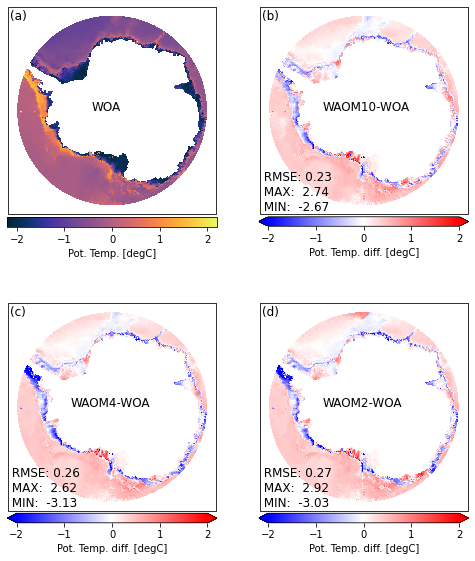

In [26]:
import string

def make_rmse(diff_s):
    return (f' RMSE: {(diff_s**2).mean().values:.2f}\n'
            f' MAX:  {diff_s.max().values:.2f}\n'
            f' MIN:  {diff_s.min().values:.2f}')


fig = plt.figure(figsize = (8.27, 10))

mask_deep = woa_t.max_depth > 0 

woa_pt = woa_t.pt.where(woa_t.depth_3d == woa_t.max_depth).max('depth').where(mask_deep)
ax1 = fig.add_subplot(221, projection = ccrs.SouthPolarStereo())
woa_pt.plot(ax=ax1,transform = ccrs.PlateCarree(),cmap=ocm.thermal,
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. [degC]','pad':0.01})

ax2 = fig.add_subplot(222, projection = ccrs.SouthPolarStereo())
(temp10_deep-woa_pt).where(mask_deep).plot(ax=ax2,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax3 = fig.add_subplot(223, projection = ccrs.SouthPolarStereo())
(temp4_deep-woa_pt).where(mask_deep).plot(ax=ax3,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})

ax4 = fig.add_subplot(224, projection = ccrs.SouthPolarStereo())
(temp2_deep-woa_pt).where(mask_deep).plot(ax=ax4,transform = ccrs.PlateCarree(),vmin=-2,vmax=2,cmap='bwr',
            cbar_kwargs={'orientation': 'horizontal','label':'Pot. Temp. diff. [degC]','pad':0.01})


n=0
for ax in [ax1,ax2,ax3,ax4]:  
    ax.text(0.01, 0.94, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
    
ax1.text(0.4, 0.5, "WOA", transform=ax1.transAxes,size=12)
ax2.text(0.3, 0.5, "WAOM10-WOA", transform=ax2.transAxes,size=12)
ax3.text(0.3, 0.5, "WAOM4-WOA", transform=ax3.transAxes,size=12)
ax4.text(0.3, 0.5, "WAOM2-WOA", transform=ax4.transAxes,size=12)

ax2.text(0.0,0.02,make_rmse(temp10_deep-woa_pt),transform=ax2.transAxes,size=12)
ax3.text(0.0,0.02,make_rmse(temp4_deep-woa_pt),transform=ax3.transAxes,size=12)
ax4.text(0.0,0.02,make_rmse(temp2_deep-woa_pt),transform=ax4.transAxes,size=12)
    #ax4.text(0.0,0.02,make_rmse(diff.salt),transform=ax4.transAxes,size=12)

#fig.subplots_adjust(bottom=0.25)
#cbar_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

#cbar = plt.colorbar(img, cax=cbar_ax,ticks=[0,50,200,500,1000,2000,4000], orientation="horizontal", pad=0.1)
#cbar.set_label(label='Depth in m',weight='bold')

#plt.subplots_adjust(wspace=0.1,hspace=0.01)

out_path = os.path.join(fig_dir,'Bottom_layer_WOA_WAOM_resolution.png')
fig.savefig(out_path,format='png',dpi=300,bbox_inches = "tight")
plt.show()

# leftovers

In [46]:
import xesmf as xe
def regrid(da):
    da = da.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
    #grd_out = xe.util.grid_2d(-180,180,1,-80.0,-64.5,1)
    regridder = xe.Regridder(da,woa_t,'nearest_s2d',reuse_weights=True)
    return regridder(da)

mask = (grd.zice==0) & (grd.lat_rho <=65)

temp_out = regrid(temp.where(mask))
salt_out = regrid(salt.where(mask))
z_out = regrid(grd.z.where(mask))
#depth_3d = regrid(grd.z.where(grd.zice==0))
#dz_out = regrid(grd.dz.where(grd.zice==0))

Reuse existing file: nearest_s2d_530x630_26x360.nc
Reuse existing file: nearest_s2d_530x630_26x360.nc
Reuse existing file: nearest_s2d_530x630_26x360.nc


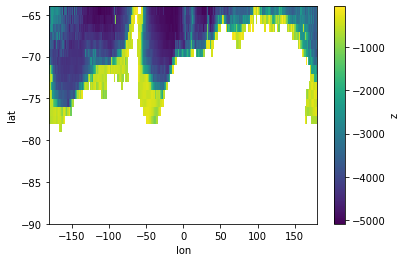

In [49]:
z_out[0].plot()

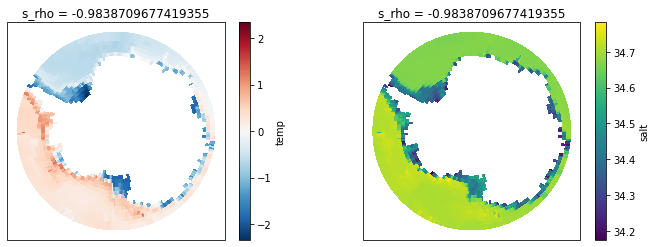

In [23]:
fig = plt.figure(figsize = (11.69, 4))
levs = np.arange(-2,-0.25,.2)

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = temp_out[0].plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = salt_out[0].plot(ax=ax2,transform = ccrs.PlateCarree())

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


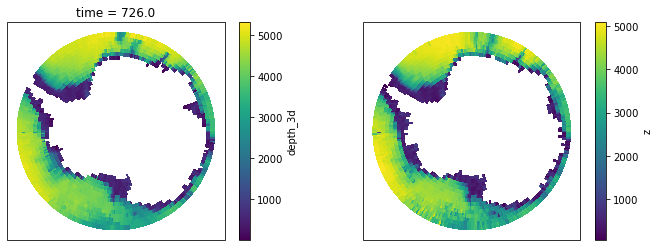

In [53]:
fig = plt.figure(figsize = (11.69, 4))
levs = np.arange(-2,-0.25,.2)

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = woa_t.depth_3d.where(woa_t.depth_3d == woa_d).max('depth').plot(ax=ax1,transform = ccrs.PlateCarree())

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = (z_out[0]*-1).plot(ax=ax2,transform = ccrs.PlateCarree())

<xarray.DataArray 't_an' (depth: 102)>
array([ 0.04541,  0.04209, -0.01321, -0.02181, -0.04301, -0.04811, -0.06241,
       -0.07391, -0.08181, -0.09971, -0.12621, -0.1518 , -0.18161, -0.21281,
       -0.23971, -0.25951, -0.26961, -0.25241, -0.22881, -0.1695 , -0.09881,
        0.43549,  0.99819,  1.37649,  1.6214 ,  1.75851,  1.85519,  1.9121 ,
        1.94161,  1.96731,  1.97911,  1.98341,  1.98531,  1.98631,  1.9814 ,
        1.97289,  1.96509,  1.94311,  1.92621,  1.89799,  1.8676 ,  1.83499,
        1.80249,  1.76809,  1.73241,  1.69669,  1.66839,  1.6337 ,  1.5973 ,
        1.56239,  1.52429,  1.48661,  1.44829,  1.41139,  1.37461,  1.33799,
        1.30199,  1.2555 ,  1.21871,  1.184  ,  1.1487 ,  1.11541,  1.0819 ,
        1.05461,  1.02459,  0.99119,  0.99501,  0.93169,  0.87481,  0.82249,
        0.76839,  0.73369,  0.59231,  0.58739,  0.59441,  0.61491,  0.60639,
        0.60311,  0.61141,  0.62561,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan], dtype=float32)
Coordinates:
    time      float32 726.0
  * depth     (depth) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
    lat       float32 -64.5
    lon       float32 -179.5
    depth_3d  (depth) float32 0.0 5.0 10.0 15.0 ... 5200.0 5300.0 5400.0 5500.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [66]:
f(woa_d[25,0])

array(0.25402418)

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate

temp_tmp = woa_t.copy()
for i in np.arange(woa_t.lat.size):
    for j in np.arange(woa_t.lon.size):
        f = interpolate(z_out)
        temp_t = intrepolate()

# WOD individual casks

In [57]:
woa_path = os.path.join(data_dir,'external','woa','ocldb1600249232.11409_CTD.nc')
woa = xr.open_dataset(woa_path,decode_times=False)

In [65]:
woa.z_row_size[0:10].sum()

<xarray.DataArray 'z_row_size' ()>
array(13792.)

In [86]:
woa

array([-65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8108,
       -65.8108, -65.8108, -65.8108, -65.8108, -65.8108, -65.8

In [119]:
woa_lats=np.repeat(woa.lat[0].values,woa.z_row_size[0])
woa_lons
for i in np.arange(1,10):
    new_lats = np.repeat(woa.lat[i].values,woa.z_row_size[i])
    woa_lats = np.concatenate((woa_lats,new_lats))   

In [97]:
np.repeat(woa.lat[i].values,woa.z_row_size[i]).astype(list)

array([-63.52510070800781, -63.52510070800781, -63.52510070800781, ...,
       -63.52510070800781, -63.52510070800781, -63.52510070800781],
      dtype=object)

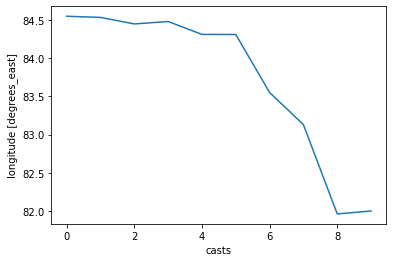

In [139]:
woa.lon[0:10].plot()

In [120]:
depth_2d,lat_2d = np.mgrid[-3644:10:10,-65.9:-63.5:0.1]

In [141]:
woa.date

<xarray.DataArray 'date' (casts: 88)>
array([20070215, 20070215, 20070215, 20070216, 20070216, 20070216, 20070216,
       20070217, 20070217, 20070217, 20070218, 20070218, 20070218, 20070218,
       20070219, 20070219, 20070219, 20070220, 20070220, 20070220, 20070220,
       20070220, 20070221, 20070221, 20070221, 20070221, 20070222, 20070222,
       20070222, 20070223, 20070224, 20070224, 20070225, 20070225, 20070226,
       20070226, 20070226, 20070226, 20070227, 20070227, 20070227, 20070228,
       20070228, 20070228, 20070301, 20070301, 20070301, 20070301, 20070302,
       20070302, 20070302, 20070303, 20070303, 20070303, 20070303, 20070304,
       20070304, 20070304, 20070305, 20070305, 20070305, 20070305, 20070306,
       20070306, 20070306, 20070307, 20070307, 20070307, 20070308, 20070308,
       20070308, 20070308, 20070309, 20070309, 20070309, 20070310, 20070310,
       20070310, 20070310, 20070311, 20070311, 20070311, 20070312, 20070312,
       20070312, 20070312, 20070312, 20070313], dtype=int32)
Coordinates:
    lat      (casts) float32 -65.8108 -65.7682 -65.7134 ... -28.9107 -28.3179
    lon      (casts) float32 84.5501 84.5348 84.4494 ... 95.007 95.0025 95.0084
    time     (casts) float64 8.661e+04 8.661e+04 ... 8.663e+04 8.663e+04
Dimensions without coordinates: casts
Attributes:
    long_name:  date
    comment:    YYYYMMDD

In [126]:
plt.pcolormesh?

In [129]:
from scipy.interpolate import griddata
g1 = griddata((-woa.z[0:13792].values,woa_lats),woa.Temperature[0:13792],(depth_2d,lat_2d),method='linear')

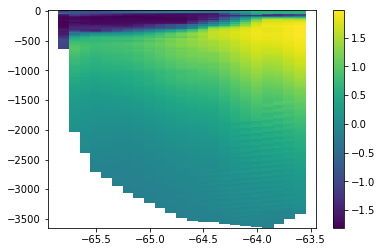

In [132]:
plt.pcolormesh(lat_2d,depth_2d,g1,shading='auto')

plt.colorbar()